In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
from ta.momentum import RSIIndicator
from ta.trend import MACD, ADXIndicator
from ta.volatility import AverageTrueRange
import matplotlib.pyplot as plt

In [3]:
def calculate_heikin_ashi(df):
    """
    Calculate Heikin-Ashi candles from regular OHLC data
    """
    ha_df = df.copy()
    
    # First create all necessary columns
    ha_df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha_df['HA_Open'] = df['open'].copy()  # Initialize with regular open values
    
    # For the first candle, HA_Open equals the regular open (already set above)
    # Calculate HA_Open for the rest
    for i in range(1, len(df)):
        ha_df.iloc[i, ha_df.columns.get_loc('HA_Open')] = (ha_df['HA_Open'].iloc[i-1] + ha_df['HA_Close'].iloc[i-1]) / 2
    
    ha_df['HA_High'] = ha_df[['high', 'HA_Open', 'HA_Close']].max(axis=1)
    ha_df['HA_Low'] = ha_df[['low', 'HA_Open', 'HA_Close']].min(axis=1)
    
    return ha_df


In [12]:
def prepare_data(symbol="BTCUSDT", interval="1h", limit=1000, use_clustering=True):
    """
    Prepare complete dataset for the trading strategy by:
    1. Fetching price data from Binance
    2. Calculating technical indicators
    3. Creating Heikin-Ashi candles
    4. Merging with clustering data if available
    
    Parameters:
    - symbol: Trading pair to analyze
    - interval: Timeframe for the data
    - limit: Number of candles to fetch
    - use_clustering: Whether to merge with clustering data
    
    Returns:
    - Complete DataFrame ready for the strategy
    """
    try:
        # First try to load data from CSV
        df = pd.read_csv('1h.csv')
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        df = df.astype({col: float for col in ['open', 'high', 'low', 'close', 'volume']})
        print("Successfully loaded data from CSV")
    except Exception as e:
        print(f"Couldn't load data from CSV: {e}")
        print("Fetching data from Binance API")
        # Fetch price data using the Client
        client = Client()
        klines = client.get_klines(symbol=symbol, interval=interval, limit=limit)
        df = pd.DataFrame(klines, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    # Calculate technical indicators
    # EMA
    df['EMA5'] = df['close'].ewm(span=5, adjust=False).mean()
    df['EMAx'] = df['close'].ewm(span=14, adjust=False).mean()
    
    # ATR
    atr_indicator = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['ATR'] = atr_indicator.average_true_range()
    
    # ADX
    adx_indicator = ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['adx'] = adx_indicator.adx()
    
    # Weekly Returns
    df['WeeklyReturns'] = df['close'].pct_change(5).fillna(0)
    
    # Calculate Heikin-Ashi candles
    df = calculate_heikin_ashi(df)
    
    # Initialize Position and Signal columns
    df['Position'] = 0
    df['Signal'] = 0
    
    # If clustering data is available and requested, ensure those columns exist
    if use_clustering and 'KMeans_Cluster' in df.columns:
        # Make sure all required columns exist
        required_cols = ['KMeans_Cluster', 'DTW_Cluster', 'KMeans_Sentiment', 'DTW_Sentiment']
        for col in required_cols:
            if col not in df.columns:
                print(f"Warning: Expected column {col} not found. Adding with default values.")
                df[col] = None
        
        # Forward fill any NaN values in the sentiment columns
        df[required_cols] = df[required_cols].ffill()
        print("Successfully processed clustering data")
    elif use_clustering:
        print("Clustering columns not found in data")
    
    # Reset index to get integer-based indexing for the strategy function
    df = df.reset_index()
    
    return df

In [13]:
def HA_and_Shortsell_with_Clusters(df, atr_multiplier=4, stoploss=0):
    """
    Enhanced trading strategy that combines Heikin-Ashi patterns with cluster analysis
    for improved market sentiment detection.
    
    Parameters:
    - df: DataFrame with price data, technical indicators, and cluster data
    - atr_multiplier: Multiplier for ATR to set stop loss distance
    - stoploss: Optional fixed stop loss value
    
    Returns:
    - DataFrame with trading signals
    """
    # Ensure Position and Signal columns exist
    if 'Position' not in df.columns:
        df['Position'] = 0
    if 'Signal' not in df.columns:
        df['Signal'] = 0
    
    stop_loss = 0
    
    # Use integer indexing since we reset the index in prepare_data
    for i in range(200, len(df)-1):
        # Get Heikin-Ashi values using iloc instead of loc
        prev_ha_close = df['HA_Close'].iloc[i-1]
        curr_ha_close = df['HA_Close'].iloc[i]
        prev_ha_open = df['HA_Open'].iloc[i-1]
        curr_ha_open = df['HA_Open'].iloc[i]
        curr_atr = df['ATR'].iloc[i]
        
        # Get cluster sentiment if available
        kmeans_sentiment = df['KMeans_Sentiment'].iloc[i] if 'KMeans_Sentiment' in df.columns else None
        dtw_sentiment = df['DTW_Sentiment'].iloc[i] if 'DTW_Sentiment' in df.columns else None
        
        # Calculate sentiment score from clusters (-1: Bearish, 0: Sideways, 1: Bullish)
        sentiment_score = 0
        if kmeans_sentiment == 'Bullish':
            sentiment_score += 1
        elif kmeans_sentiment == 'Bearish':
            sentiment_score -= 1
            
        if dtw_sentiment == 'Bullish':
            sentiment_score += 1
        elif dtw_sentiment == 'Bearish':
            sentiment_score -= 1
        
        # Original bearish condition with added cluster sentiment
        if (df['close'].iloc[i] < df['EMAx'].iloc[i-1] and 
            df['low'].iloc[i-1] > df['EMA5'].iloc[i-1] and 
            df['close'].iloc[i] < df['low'].iloc[i-1] and 
            df['Position'].iloc[i] == 0 and
            (sentiment_score <= 0 or 'KMeans_Sentiment' not in df.columns)):  # Added sentiment check
                
            df.loc[i+1, 'Position'] = -1
            df.loc[i, 'Signal'] = -df.loc[i, 'Position']
            stop_loss = df['high'].iloc[i-1] + 2*df['ATR'].iloc[i-1]
        
        # Original long condition with added cluster sentiment
        elif (df['close'].iloc[i] > df['EMAx'].iloc[i-1] and 
              prev_ha_close > prev_ha_open and 
              curr_ha_close > curr_ha_open and 
              df['adx'].iloc[i] < 25 and 
              df['Position'].iloc[i] != 1 and
              (sentiment_score >= 0 or 'KMeans_Sentiment' not in df.columns)):  # Added sentiment check
            
            df.loc[i+1, 'Position'] = 1
            df.loc[i, 'Signal'] = 1 - df.loc[i, 'Position']
            stop_loss = df['high'].iloc[i] - curr_atr * (atr_multiplier+1)
        
        # Original short condition with added cluster sentiment
        elif (df['close'].iloc[i] > df['EMAx'].iloc[i-1] and 
              prev_ha_close > prev_ha_open and 
              curr_ha_close < curr_ha_open and 
              df['adx'].iloc[i] < 25 and 
              df['Position'].iloc[i] != -1 and
              (sentiment_score <= 0 or 'KMeans_Sentiment' not in df.columns)):  # Added sentiment check
            
            df.loc[i+1, 'Position'] = -1
            df.loc[i, 'Signal'] = -1 - df.loc[i, 'Position']
            stop_loss = df['low'].iloc[i] + curr_atr * (atr_multiplier-1)
        
        # Secondary long condition with enhanced cluster logic
        elif (df['adx'].iloc[i] > 60 and 
              df['Position'].iloc[i] != 1 and 
              df['WeeklyReturns'].iloc[i] < 0 and
              (sentiment_score > 0 or 'KMeans_Sentiment' not in df.columns)):  # Strong bullish sentiment preferred
            
            df.loc[i+1, 'Position'] = 1
            df.loc[i, 'Signal'] = 1 - df.loc[i, 'Position']
            stop_loss = df['high'].iloc[i] - curr_atr * (atr_multiplier+1)
        
        # Secondary short condition with enhanced cluster logic
        elif (df['adx'].iloc[i] > 60 and 
              df['Position'].iloc[i] != -1 and 
              df['WeeklyReturns'].iloc[i] > 0 and
              (sentiment_score < 0 or 'KMeans_Sentiment' not in df.columns)):  # Strong bearish sentiment preferred
            
            df.loc[i+1, 'Position'] = -1
            df.loc[i, 'Signal'] = -1 - df.loc[i, 'Position']
            stop_loss = df['low'].iloc[i] + curr_atr * (atr_multiplier-1)
        
        # New condition: Exit positions when sentiment changes against current position
        elif ('KMeans_Sentiment' in df.columns and
              ((df['Position'].iloc[i] == 1 and sentiment_score < -1) or  # Strong bearish against long
               (df['Position'].iloc[i] == -1 and sentiment_score > 1))):   # Strong bullish against short
            
            df.loc[i+1, 'Position'] = 0
            df.loc[i, 'Signal'] = -df.loc[i, 'Position']
        
        else:
            # Manage existing positions with stop loss
            if df['Position'].iloc[i] == 1:
                df.loc[i+1, 'Position'] = 1
                if df['low'].iloc[i] < stop_loss:
                    df.loc[i+1, 'Position'] = 0
                    df.loc[i, 'Signal'] = -1
                else:
                    stop_loss = max(stop_loss, df['high'].iloc[i] - curr_atr * (atr_multiplier+1))
            
            elif df['Position'].iloc[i] == -1:
                df.loc[i+1, 'Position'] = -1
                if df['high'].iloc[i] > stop_loss:
                    df.loc[i+1, 'Position'] = 0
                    df.loc[i, 'Signal'] = 1
                else:
                    stop_loss = min(stop_loss, df['low'].iloc[i] + curr_atr * (atr_multiplier-1))
            
            else:
                df.loc[i+1, 'Position'] = 0
    
    # Restore timestamp index for visualization and analysis
    if 'timestamp' in df.columns:
        df = df.set_index('timestamp')
    
    return df


In [14]:
def analyze_strategy_performance(df):
    """
    Calculate and display performance metrics for the trading strategy.
    
    Parameters:
    - df: DataFrame with Position and close price columns
    
    Returns:
    - Dictionary of performance metrics
    """
    # Calculate returns based on positions
    df['Strategy_Returns'] = df['Position'].shift(1) * df['close'].pct_change()
    df['Cumulative_Returns'] = (1 + df['Strategy_Returns'].fillna(0)).cumprod() - 1
    
    # Calculate performance metrics
    total_return = df['Cumulative_Returns'].iloc[-1]
    # Avoid division by zero
    sharpe_ratio = df['Strategy_Returns'].mean() / max(df['Strategy_Returns'].std(), 1e-8) * np.sqrt(252)  # Annualized
    max_drawdown = (df['Cumulative_Returns'] - df['Cumulative_Returns'].cummax()).min()
    # Avoid division by zero
    win_count = len(df[df['Strategy_Returns'] > 0])
    total_trades = len(df[df['Strategy_Returns'] != 0])
    win_rate = win_count / max(total_trades, 1)
    
    performance = {
        'Total Return': f"{total_return:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Win Rate': f"{win_rate:.2%}",
        'Total Trades': total_trades
    }
    
    return performance

def plot_strategy_results(df, title="Strategy Performance"):
    """
    Plot the trading strategy results including:
    - Price chart with buy/sell signals
    - Equity curve
    
    Parameters:
    - df: DataFrame with strategy results
    - title: Title for the plot
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot price
    ax1.plot(df.index, df['close'], label='Price', color='black', alpha=0.5)
    
    # Plot buy signals
    buy_signals = df[df['Signal'] == 1]
    if not buy_signals.empty:
        ax1.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', s=100, label='Buy')
    
    # Plot sell signals
    sell_signals = df[df['Signal'] == -1]
    if not sell_signals.empty:
        ax1.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', s=100, label='Sell')
    
    # Plot cluster sentiment changes if available
    if 'KMeans_Sentiment' in df.columns:
        sentiment_changes = df[df['KMeans_Sentiment'] != df['KMeans_Sentiment'].shift(1)]
        
        bullish_changes = sentiment_changes[sentiment_changes['KMeans_Sentiment'] == 'Bullish']
        if not bullish_changes.empty:
            ax1.scatter(bullish_changes.index, bullish_changes['close']*0.99, marker='*', color='green', s=50, alpha=0.5, label='Bullish Sentiment')
        
        bearish_changes = sentiment_changes[sentiment_changes['KMeans_Sentiment'] == 'Bearish']
        if not bearish_changes.empty:
            ax1.scatter(bearish_changes.index, bearish_changes['close']*1.01, marker='*', color='red', s=50, alpha=0.5, label='Bearish Sentiment')
    
    ax1.set_title(f'{title} - Price and Signals')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot equity curve
    ax2.plot(df.index, df['Cumulative_Returns'], label='Strategy Returns', color='blue')
    ax2.plot(df.index, df['close'].pct_change().fillna(0).cumsum(), label='Buy & Hold', color='grey', alpha=0.5)
    ax2.set_title('Equity Curve')
    ax2.set_ylabel('Returns')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('strategy_results.png')
    plt.show()


Couldn't load data from CSV: 'timestamp'
Fetching data from Binance API
Clustering columns not found in data

===== STRATEGY PERFORMANCE =====
Total Return: 10.03%
Sharpe Ratio: 0.41
Max Drawdown: -11.17%
Win Rate: 54.46%
Total Trades: 560


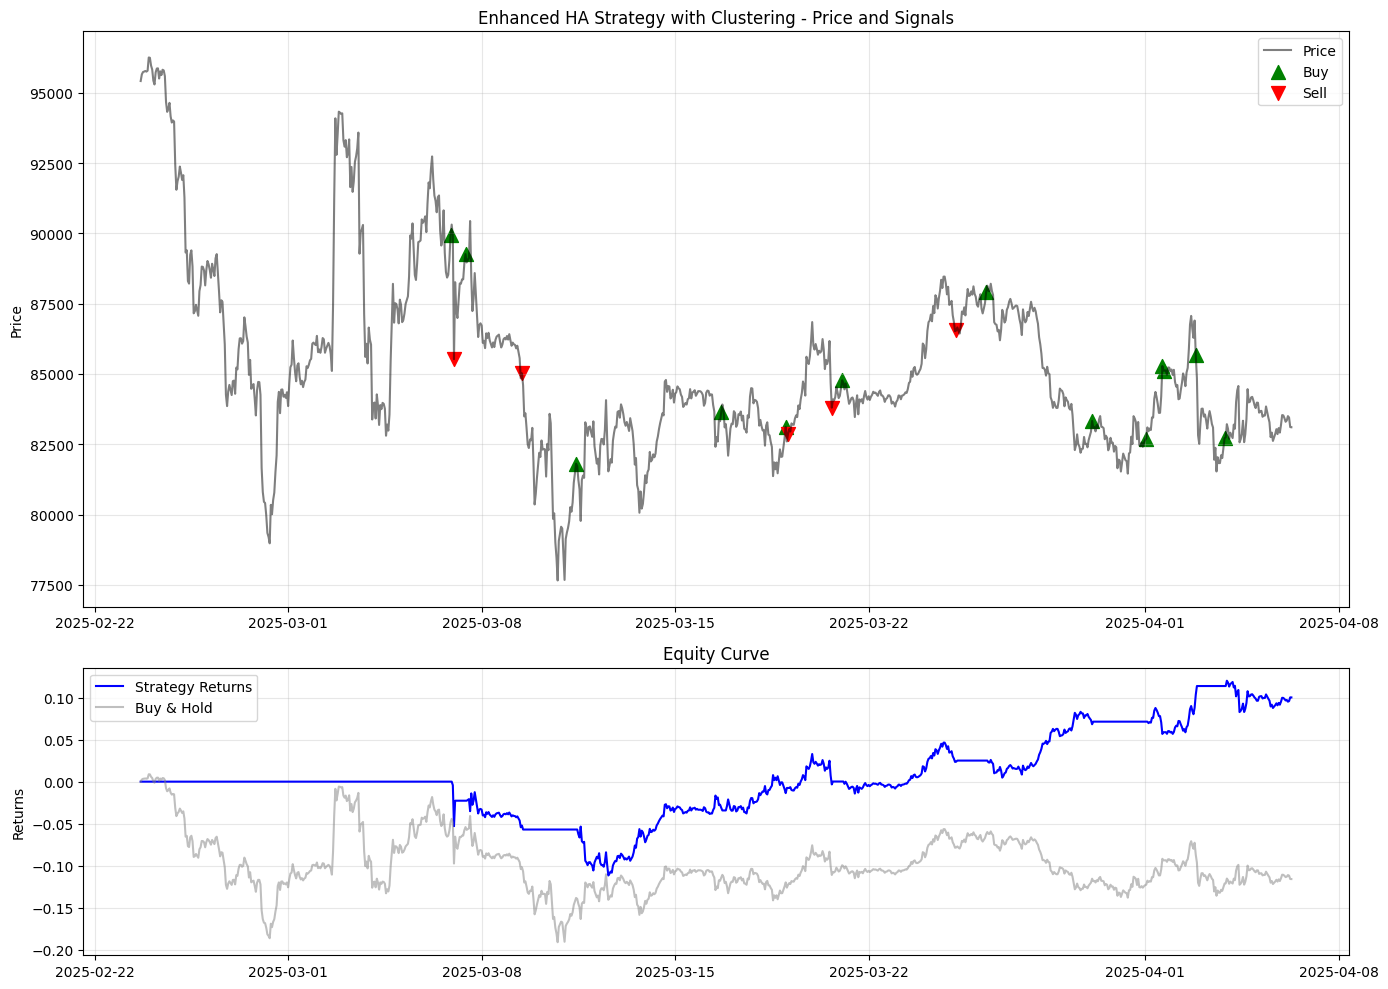

In [15]:
def run_strategy_pipeline():
    """
    Complete end-to-end pipeline to fetch data, run the strategy, analyze performance,
    and visualize results.
    """
    # Step 1: Prepare data by integrating with 7.py output
    df = prepare_data(symbol="BTCUSDT", interval="1h", limit=1000, use_clustering=True)
    
    # Step 2: Run the enhanced strategy
    df = HA_and_Shortsell_with_Clusters(df, atr_multiplier=4)
    
    # Step 3: Analyze performance
    performance = analyze_strategy_performance(df)
    
    print("\n===== STRATEGY PERFORMANCE =====")
    for metric, value in performance.items():
        print(f"{metric}: {value}")
    
    # Step 4: Visualize results
    plot_strategy_results(df, title="Enhanced HA Strategy with Clustering")
    
    # Step 5: Save results
    df.to_csv("strategy_results_with_clusters.csv")
    
    return df, performance

# Enable direct execution
if __name__ == "__main__":
    # Run the complete pipeline
    df, performance = run_strategy_pipeline()